# Model Optimization
___

In [1]:
# MUST be the first cell in the notebook
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import random
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
import sys
from utils import load_it_data, visualize_img, compute_ev_and_corr
import matplotlib.pyplot as plt

import numpy as np
import gdown

In [2]:
def set_seed(seed=0):
    print('Deterministic code, set seed to', seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed = 6
set_seed(seed=seed)

Deterministic code, set seed to 6


In [3]:
import sys
!{sys.executable} -m pip install gdown h5py

In [4]:
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS
From (redirected): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS&confirm=t&uuid=92c59330-a5af-4896-a5fc-93e17096c009
To: /content/IT_data.h5
100%|██████████| 384M/384M [00:01<00:00, 249MB/s]


'IT_data.h5'

## Load the data

In [5]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [6]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


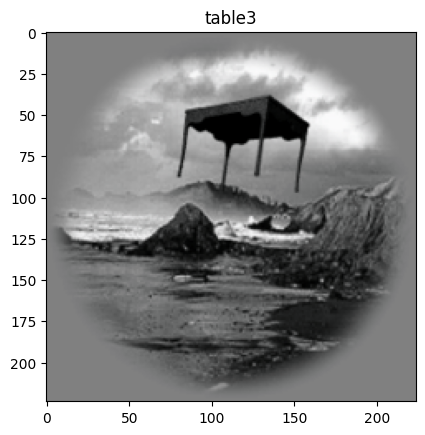

In [7]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

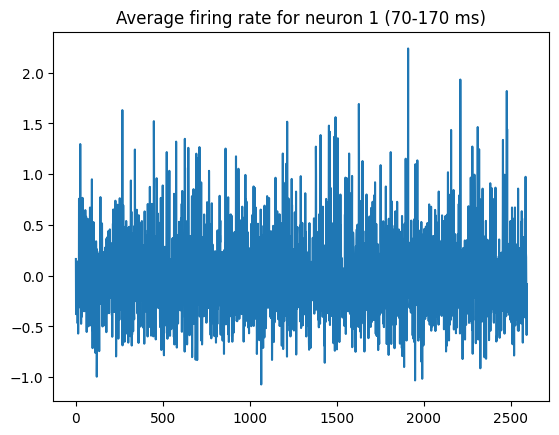

In [8]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

___

# In search for the best model:

### _Funtions used in this part of the notebook_

In [50]:
class ITNeuralActivity(Dataset):
    def __init__(self, X, y=None, transform=None):
        """
        Custom Dataset for IT neural activity prediction.

        Args:
            X (numpy array): Input stimuli (e.g., images).
            y (numpy array, optional): Neural activity (e.g., spikes). Default is None for test data.
            transform (callable, optional): Optional transform to be applied on the input stimuli.
        """
        self.X = X
        self.y = torch.from_numpy(y).float() if y is not None else None
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]
        neural_activity = self.y[idx] if self.y is not None else None

        if self.transform:
            img = self.transform(torch.from_numpy(img).float())

        return (img, neural_activity) if neural_activity is not None else img


# Define the transform
transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets with the transform
train_dataset = ITNeuralActivity(stimulus_train, spikes_train, transform=transform)
val_dataset = ITNeuralActivity(stimulus_val, spikes_val, transform=transform)
test_dataset = ITNeuralActivity(stimulus_test, transform=transform)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [51]:
def train_model(model, train_dataloader, val_dataloader, loss_function, optimizer, epochs=10, device='cpu', scheduler=None):
    """
    Train the model and validate it after each epoch.

    Args:
        model (nn.Module): The neural network model.
        train_dataloader (DataLoader): DataLoader for training data.
        val_dataloader (DataLoader): DataLoader for validation data.
        loss_function (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        epochs (int): Number of training epochs.

    Returns:
        None
    """
    model.to(device)

    from torch.optim.swa_utils import AveragedModel, SWALR, update_bn
    swa_model     = AveragedModel(model)
    swa_start_ep  = 5                      # start averaging once val loss flattens
    swa_scheduler = SWALR(optimizer, swa_lr=1e-4)

    # Learning rate scheduler
    if scheduler is None:
        # Use StepLR scheduler with step size of 5 and gamma of 0.1
        scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for images, spikes in train_dataloader:
            images, spikes = images.to(device), spikes.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_function(outputs, spikes)

            # Backward pass & optimization
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, spikes in val_dataloader:
                images, spikes = images.to(device), spikes.to(device)

                # Forward pass
                outputs = model(images)
                loss = loss_function(outputs, spikes)

                val_loss += loss.item()

        # Step the learning rate scheduler
        scheduler.step()

        if epoch >= swa_start_ep:
          swa_model.update_parameters(model)
          swa_scheduler.step()

        # Print epoch results
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_dataloader):.4f}, "
              f"Val Loss: {val_loss/len(val_dataloader):.4f}")

        # Stop training if loss becomes NaN or Inf
        if torch.isnan(torch.tensor(train_loss)) or torch.isinf(torch.tensor(train_loss)):
            print("Training stopped due to unstable loss (NaN or Inf).")
            break

    # --- SWA finalisation (after the epoch loop) ---
    update_bn(train_dataloader, swa_model, device=device)

    # If swa_model came from a DataParallel‑wrapped network,
    # keep the inner module; otherwise keep swa_model itself.
    model = swa_model.module if hasattr(swa_model, "module") else swa_model


In [52]:
def evaluate_model(model, dataloader, spikes_val, device='cpu'):
    """
    Evaluate the model using explained variance and correlation.

    Args:
        model (nn.Module): The trained model.
        dataloader (DataLoader): DataLoader for the dataset to evaluate.
        spikes_val (numpy array): Ground truth neural activity for validation.
        loss_function (nn.Module, optional): Loss function (if needed for logging).
        device (str): Device to evaluate on ('cpu' or 'cuda').

    Returns:
        None
    """
    model.to(device)
    model.eval()

    # Compute explained variance & correlation
    overall_ev, overall_corr, ev_per_neuron, corr_per_neuron = compute_ev_and_corr(model, dataloader, spikes_val)

    print(f'Overall explained variance: {overall_ev:.4f}')
    print(f'Overall correlation: {overall_corr:.4f}')

    # Plot histograms for explained variance & correlation
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].hist(ev_per_neuron, bins=20, color='blue', alpha=0.7, edgecolor='black')
    axs[0].set_title('Explained Variance per Neuron')
    axs[0].set_xlabel('Explained Variance')
    axs[0].set_ylabel('Frequency')

    axs[1].hist(corr_per_neuron, bins=20, color='green', alpha=0.7, edgecolor='black')
    axs[1].set_title('Correlation per Neuron')
    axs[1].set_xlabel('Correlation Coefficient')
    axs[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

___

### DeepNet201

### Define the model



In [53]:
from torchvision.models import densenet201, DenseNet201_Weights

# Load ImageNet‑pretrained backbone
backbone = densenet201(weights=DenseNet201_Weights.IMAGENET1K_V1)

# Replace classifier: DenseNet uses nn.Linear(in_features, 1000) by default
in_features = backbone.classifier.in_features
n_neurons = spikes_train.shape[1]

backbone.classifier = nn.Linear(in_features, n_neurons)

model = backbone.cuda()
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")


Model parameters: 18,415,656


### Define the loss function and the optimizer




In [54]:
import torch.optim as optim

# Define the loss function
loss_function = nn.MSELoss()

# Define the optimizer
learning_rate = 0.001

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  ### Define a Scheduler

In [55]:
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR

base_lr     = 1e-3        # same as now
num_epochs  = 15          # keep your 15‑epoch budget
warmup_ep   = 2

warmup = LinearLR(optimizer,
                  start_factor=0.1,      # 0.1 × base_lr
                  end_factor=1.0,
                  total_iters=warmup_ep)

cosine = CosineAnnealingLR(optimizer,
                           T_max=num_epochs - warmup_ep,
                           eta_min=base_lr * 1e-3)   # ends 1000× lower

scheduler = SequentialLR(optimizer,
                         schedulers=[warmup, cosine],
                         milestones=[warmup_ep])



### Train model

In [56]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_model(model, train_dataloader, val_dataloader, loss_function, optimizer, epochs=10, device=device, scheduler = scheduler)


Epoch 1/10, Train Loss: 0.1205, Val Loss: 0.0918


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2/10, Train Loss: 0.0868, Val Loss: 0.0960
Epoch 3/10, Train Loss: 0.0783, Val Loss: 0.0808
Epoch 4/10, Train Loss: 0.0686, Val Loss: 0.0735
Epoch 5/10, Train Loss: 0.0610, Val Loss: 0.0674
Epoch 6/10, Train Loss: 0.0582, Val Loss: 0.0653
Epoch 7/10, Train Loss: 0.0488, Val Loss: 0.0688
Epoch 8/10, Train Loss: 0.0402, Val Loss: 0.0606
Epoch 9/10, Train Loss: 0.0328, Val Loss: 0.0629
Epoch 10/10, Train Loss: 0.0272, Val Loss: 0.0589


### Evaluate model

Overall explained variance: 0.4937
Overall correlation: 0.6971


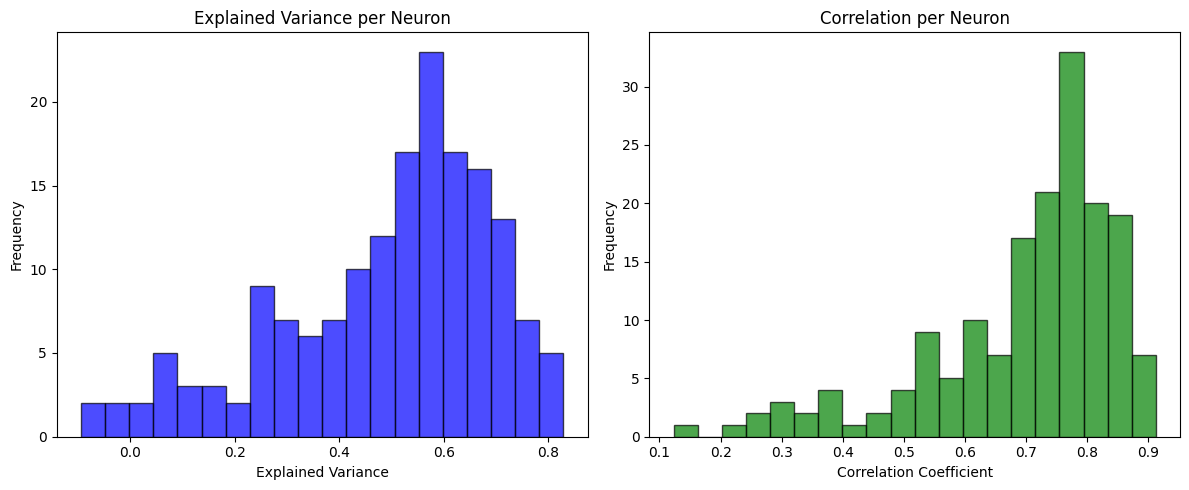

In [57]:
# Evaluate model on the validation set
evaluate_model(model, val_dataloader, spikes_val, device="cpu")

In [58]:
torch.save(model.state_dict(), 'best_model.pth')

> Reducing the number of training epochs led to better performance by mitigating overfitting. Additionally, switching to a linear warm-up learning rate scheduler significantly improved model stability. While several optimizers were tested, Adam consistently yielded the best results for our implementation.



___

### ResNet‑152

### Define the model

In [59]:
from torchvision.models import resnet152, ResNet152_Weights

# load ImageNet‑pretrained ResNet‑152 (pre‑activation = "v2")
backbone = resnet152(weights=ResNet152_Weights.IMAGENET1K_V2)

# swap the 1000‑way classifier for NUM_NEURONS regression head
in_features = backbone.fc.in_features          # 2048
backbone.fc = nn.Linear(in_features, n_neurons)

model2 = backbone.cuda()
print(f"ResNet‑152 params: {sum(p.numel() for p in model2.parameters()):,}")


ResNet‑152 params: 58,488,040


### Define the optimizer

In [60]:
import torch.optim as optim

# Define the optimizer
learning_rate = 0.001
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)

#NOTE: using the same loss function as before (MSE)

### Train model

In [61]:
# Using the scheduler defined with DenseNet201
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_model(model2, train_dataloader, val_dataloader, loss_function, optimizer, epochs=10, device=device, scheduler = scheduler)

Epoch 1/10, Train Loss: 0.1034, Val Loss: 0.0912
Epoch 2/10, Train Loss: 0.0774, Val Loss: 0.0782
Epoch 3/10, Train Loss: 0.0651, Val Loss: 0.0718
Epoch 4/10, Train Loss: 0.0546, Val Loss: 0.0689
Epoch 5/10, Train Loss: 0.0471, Val Loss: 0.0684
Epoch 6/10, Train Loss: 0.0403, Val Loss: 0.0652
Epoch 7/10, Train Loss: 0.0342, Val Loss: 0.0661
Epoch 8/10, Train Loss: 0.0279, Val Loss: 0.0647
Epoch 9/10, Train Loss: 0.0219, Val Loss: 0.0645
Epoch 10/10, Train Loss: 0.0165, Val Loss: 0.0658


### Evaluate model

Overall explained variance: 0.4439
Overall correlation: 0.6596


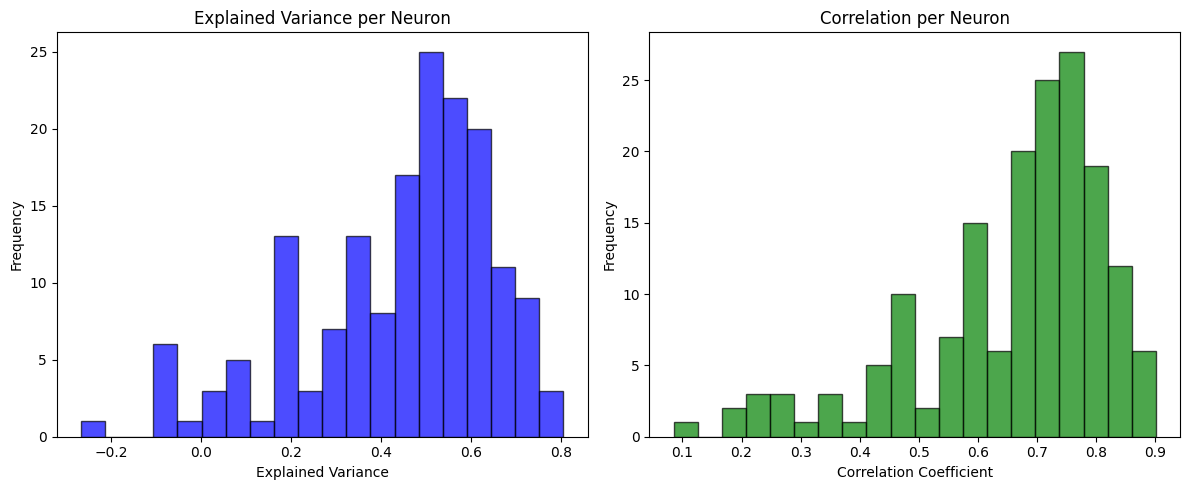

In [62]:
# Evaluate model on the validation set
evaluate_model(model2, val_dataloader, spikes_val, device="cpu")

___

### pnasnet5large




### Define the model

In [63]:
# ------------------------------------------------------------------
#  PNASNet‑5 Large backbone pretrained on ImageNet‑1k
# ------------------------------------------------------------------
import timm, torch.nn as nn

backbone = timm.create_model("pnasnet5large", pretrained=True)

# ------------------------------------------------------------------
#  Replace the ImageNet head with a NUM_NEURONS regression head
#     timm models use different attribute names, so check in order
# ------------------------------------------------------------------
if hasattr(backbone, "classifier"):          # many EfficientNet‑style models
    in_features = backbone.classifier.in_features
    backbone.classifier = nn.Linear(in_features, n_neurons)
elif hasattr(backbone, "fc"):                # ResNet‑style
    in_features = backbone.fc.in_features
    backbone.fc = nn.Linear(in_features, n_neurons)
elif hasattr(backbone, "head"):              # ViT / ConvNeXt‑style
    in_features = backbone.head.in_features
    backbone.head = nn.Linear(in_features, n_neurons)
elif hasattr(backbone, "last_linear"):       # Inception / PNASNet
    in_features = backbone.last_linear.in_features
    backbone.last_linear = nn.Linear(in_features, n_neurons)
else:
    raise AttributeError("Cannot locate final classifier layer.")

model3 = backbone.cuda()
print(f"PNASNet‑5 Large parameters: {sum(p.numel() for p in model3.parameters()):,}")


PNASNet‑5 Large parameters: 82,462,596


### Define the optimizer

In [64]:
optimizer = optim.AdamW(model3.parameters(), lr=learning_rate)

# NOTE: using the same loss function as before (MSE)

### Train the model

In [65]:
# Using scheduler defined before...
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_model(model3, train_dataloader, val_dataloader, loss_function, optimizer, epochs=15, device=device, scheduler=scheduler)

Epoch 1/15, Train Loss: 0.1184, Val Loss: 0.1085
Epoch 2/15, Train Loss: 0.0970, Val Loss: 0.0957
Epoch 3/15, Train Loss: 0.0849, Val Loss: 0.0888
Epoch 4/15, Train Loss: 0.0762, Val Loss: 0.0796
Epoch 5/15, Train Loss: 0.0706, Val Loss: 0.0784
Epoch 6/15, Train Loss: 0.0652, Val Loss: 0.0771
Epoch 7/15, Train Loss: 0.0609, Val Loss: 0.0730
Epoch 8/15, Train Loss: 0.0573, Val Loss: 0.0678
Epoch 9/15, Train Loss: 0.0533, Val Loss: 0.0663
Epoch 10/15, Train Loss: 0.0495, Val Loss: 0.0669
Epoch 11/15, Train Loss: 0.0455, Val Loss: 0.0638
Epoch 12/15, Train Loss: 0.0419, Val Loss: 0.0621
Epoch 13/15, Train Loss: 0.0382, Val Loss: 0.0613
Epoch 14/15, Train Loss: 0.0355, Val Loss: 0.0601
Epoch 15/15, Train Loss: 0.0332, Val Loss: 0.0600


### Evaluate the model

Overall explained variance: 0.4894
Overall correlation: 0.6890


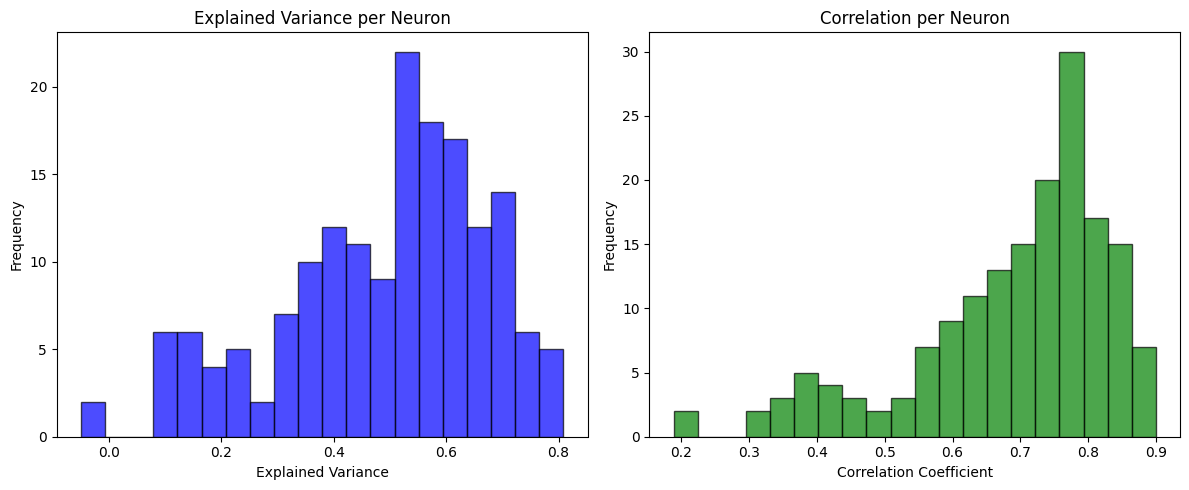

In [66]:
# Evaluate model on the validation set
evaluate_model(model3, val_dataloader, spikes_val, device="cpu")


---

### **Model Performance Summary**

| Model           | Overall Explained Variance | Overall Correlation |
| --------------- | -------------------------- | ------------------- |
| **DenseNet201** | **0.4937**                 | **0.6971**          |
| PNASNet-5 Large | 0.4894                     | 0.6890              |
| ResNet152       | 0.4439                     | 0.6596              |

---

### **Discussion**

Among the evaluated architectures, **DenseNet201** yields the strongest performance, achieving the highest explained variance and correlation with ground truth neural responses. Its densely connected layers likely promote richer feature reuse and more robust gradient flow, making it well-suited for capturing the structure of neural activity.

**PNASNet-5 Large** closely follows DenseNet201, with only marginally lower scores. This suggests that its architecture—discovered via neural architecture search—is effective at extracting features that generalize well to neural data, even though it was not explicitly designed for this task.

**ResNet152**, while deep and expressive, performs notably worse. This implies that residual connections alone do not guarantee optimal neural predictivity, and its representational geometry may not align as naturally with the underlying structure of neural spike patterns.

In short:

* **DenseNet201** provides the best overall alignment with neural activity.
* **PNASNet-5 Large** is a strong alternative, nearly matching DenseNet's performance.
* **ResNet152** trails behind, suggesting architectural limitations in this context.



---

# Part 2: Predict the neural activity with the task-driven modeling approach on this notebook's models


In [9]:
from torchvision import models, transforms
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score
from scipy.stats import pearsonr
from torch.utils.data import DataLoader

In [10]:
# Make sure were using the fastest option:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### _Custom Stimuli Dataset Class Definition_

In [11]:
class StimuliDataset(torch.utils.data.Dataset):
    """
    Custom Dataset for loading visual stimuli and optional neural response data.

    Parameters
    ----------
    stimuli : np.ndarray or list
        A collection of image stimuli, expected as a NumPy array or list of arrays.
    responses : np.ndarray or list, optional
        Corresponding neural response vectors for each stimulus. If None, dataset returns only stimuli.
    transform : callable, optional
        A function/transform to apply to each stimulus (e.g., normalization).

    Methods
    -------
    __len__():
        Returns the number of samples in the dataset.

    __getitem__(idx):
        Returns the transformed stimulus and corresponding response (if available) at the given index.
    """

    def __init__(self, stimuli, responses=None, transform=None):
        self.stimuli = stimuli
        self.responses = responses
        self.transform = transform

    def __len__(self):
        return len(self.stimuli)

    def __getitem__(self, idx):
        x = self.stimuli[idx]
        if self.transform:
            x = self.transform(torch.tensor(x).float())
        return (x, self.responses[idx]) if self.responses is not None else x

### _Data Preparation: Datasets, Transforms, and DataLoaders_

In [12]:
transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = StimuliDataset(stimulus_train, spikes_train, transform=transform)
val_dataset = StimuliDataset(stimulus_val, spikes_val, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

### _Activation Extraction Utility Function_

In [13]:
def extract_activations(model, loader, layer_name):
    """
    Extracts and flattens activations from a specified layer of a model for all inputs in a DataLoader.

    Parameters
    ----------
    model : torch.nn.Module
        The neural network model from which to extract activations.
    loader : torch.utils.data.DataLoader
        DataLoader providing input data in batches.
    layer_name : str
        Name of the layer (as registered in model.named_modules()) to hook and extract activations from.

    Returns
    -------
    np.ndarray
        A NumPy array of shape (N, D) where N is the number of samples and D is the flattened activation dimension
        from the specified layer.
    """
    activations = []

    def hook_fn(module, input, output):
        activations.append(output.detach().cpu().numpy().reshape(output.size(0), -1))

    hook = dict(model.named_modules())[layer_name].register_forward_hook(hook_fn)

    with torch.no_grad():
        for batch in loader:
            imgs = batch[0].to(device)
            _ = model(imgs)

    hook.remove()

    return np.concatenate(activations, axis=0)


### _Visulaization function_

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def plot_ev_corr_comparison(model_name, layers_labels, results_pre, results_rand):
    explained_vars_pre = [results_pre[layer]['explained_variance'] for layer in layers_labels]
    correlations_pre = [results_pre[layer]['mean_correlation'] for layer in layers_labels]
    explained_vars_rand = [results_rand[layer]['explained_variance'] for layer in layers_labels]
    correlations_rand = [results_rand[layer]['mean_correlation'] for layer in layers_labels]

    fig, ax1 = plt.subplots(figsize=(12, 5))

    # Explained Variance (left axis)
    color_ev_pre = 'tab:blue'
    color_ev_rand = 'tab:cyan'
    ax1.set_xlabel('Layers')
    ax1.set_ylabel('Explained Variance', color=color_ev_pre)
    ax1.plot(layers_labels, explained_vars_pre, color=color_ev_pre, marker='o', label='Explained Variance (Pretrained)')
    ax1.plot(layers_labels, explained_vars_rand, color=color_ev_rand, marker='o', linestyle='--', label='Explained Variance (Random)')
    ax1.tick_params(axis='y', labelcolor=color_ev_pre)

    # Mean Correlation (right axis)
    ax2 = ax1.twinx()
    color_corr_pre = 'tab:green'
    color_corr_rand = 'tab:olive'
    ax2.set_ylabel('Mean Correlation', color=color_corr_pre)
    ax2.plot(layers_labels, correlations_pre, color=color_corr_pre, marker='x', label='Mean Correlation (Pretrained)')
    ax2.plot(layers_labels, correlations_rand, color=color_corr_rand, marker='x', linestyle='--', label='Mean Correlation (Random)')
    ax2.tick_params(axis='y', labelcolor=color_corr_pre)

    # Combined legend
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)
    plt.title(f'Comparison of Pretrained and Random Model Performance across Layers ({model_name})')
    fig.tight_layout()
    plt.show()




def plot_neuron_metrics_hist(model_name, spikes_val, preds_val_pre, preds_val_rand):
    # Explained variance per neuron
    ev_pre = 1 - np.var(spikes_val - preds_val_pre, axis=0) / np.var(spikes_val, axis=0)
    ev_rand = 1 - np.var(spikes_val - preds_val_rand, axis=0) / np.var(spikes_val, axis=0)

    # Pearson correlation per neuron
    corr_pre = [pearsonr(spikes_val[:, i], preds_val_pre[:, i])[0] for i in range(spikes_val.shape[1])]
    corr_rand = [pearsonr(spikes_val[:, i], preds_val_rand[:, i])[0] for i in range(spikes_val.shape[1])]

    # Plot histograms
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    axs[0, 0].hist(ev_pre, bins=20, color='tab:blue', alpha=0.7, edgecolor='black')
    axs[0, 0].set_title('Explained Variance per Neuron (Pretrained)')
    axs[0, 0].set_xlabel('Explained Variance')
    axs[0, 0].set_ylabel('Frequency')

    axs[0, 1].hist(ev_rand, bins=20, color='tab:cyan', alpha=0.7, edgecolor='black')
    axs[0, 1].set_title('Explained Variance per Neuron (Random)')
    axs[0, 1].set_xlabel('Explained Variance')
    axs[0, 1].set_ylabel('Frequency')

    axs[1, 0].hist(corr_pre, bins=20, color='tab:green', alpha=0.7, edgecolor='black')
    axs[1, 0].set_title('Correlation per Neuron (Pretrained)')
    axs[1, 0].set_xlabel('Correlation Coefficient')
    axs[1, 0].set_ylabel('Frequency')

    axs[1, 1].hist(corr_rand, bins=20, color='tab:olive', alpha=0.7, edgecolor='black')
    axs[1, 1].set_title('Correlation per Neuron (Random)')
    axs[1, 1].set_xlabel('Correlation Coefficient')
    axs[1, 1].set_ylabel('Frequency')

    plt.suptitle(f'Neuron-Level Performance Comparison: Pretrained vs Random ({model_name})', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


## Densenet201

### _Layer-wise Evaluation: PCA + Linear Regression on Pretrained Densenet201_

In [14]:
from torchvision.models import densenet201, DenseNet201_Weights

# Load ImageNet‑pretrained backbone
backbone_pre = densenet201(weights=DenseNet201_Weights.IMAGENET1K_V1)

# Replace classifier: DenseNet uses nn.Linear(in_features, 1000) by default
in_features = backbone_pre.classifier.in_features
n_neurons = spikes_train.shape[1]

backbone_pre.classifier = nn.Linear(in_features, n_neurons)

model_pre = backbone_pre.cuda()
print(f"Model parameters: {sum(p.numel() for p in model_pre.parameters()):,}")
layers = [
    'features.conv0',
    'features.denseblock1',
    'features.denseblock2',
    'features.denseblock3',
    'features.denseblock4',
    'features.norm5'
]

results = {}

for layer in layers:
    print(f'Processing {layer}')

    # Extract activations
    train_act = extract_activations(model_pre, train_loader, layer)
    val_act = extract_activations(model_pre, val_loader, layer)

    # PCA (use min for safety)
    n_components = min(1000, train_act.shape[1])
    pca = PCA(n_components=n_components, random_state=42)
    X_train_pcs = pca.fit_transform(train_act)
    X_val_pcs = pca.transform(val_act)

    # Linear Regression
    lr = LinearRegression().fit(X_train_pcs, spikes_train)
    preds_val = lr.predict(X_val_pcs)

    # Evaluation metrics
    ev = explained_variance_score(spikes_val, preds_val)
    correlations = [pearsonr(spikes_val[:, i], preds_val[:, i])[0] for i in range(spikes_val.shape[1])]
    avg_corr = np.mean(correlations)

    results[layer] = {'explained_variance': ev, 'mean_correlation': avg_corr}

    print(f"{layer} | EV: {ev:.4f}, Mean Corr: {avg_corr:.4f}")


Model parameters: 18,415,656
Processing features.conv0
features.conv0 | EV: -0.0760, Mean Corr: 0.2165
Processing features.denseblock1
features.denseblock1 | EV: 0.2242, Mean Corr: 0.4719
Processing features.denseblock2
features.denseblock2 | EV: 0.2823, Mean Corr: 0.5306
Processing features.denseblock3
features.denseblock3 | EV: 0.3871, Mean Corr: 0.6178
Processing features.denseblock4
features.denseblock4 | EV: 0.3929, Mean Corr: 0.6253
Processing features.norm5
features.norm5 | EV: 0.3228, Mean Corr: 0.5724


### _Layer-wise Evaluation: PCA + Linear Regression on Randomly Initialized Densenet201_

In [30]:
from torchvision.models import densenet201, DenseNet201_Weights

# Load ImageNet backbone NO Pretrainig
backbone_rand = densenet201(weights=None)

# Replace classifier: DenseNet uses nn.Linear(in_features, 1000) by default
in_features = backbone_rand.classifier.in_features
n_neurons = spikes_train.shape[1]

backbone_rand.classifier = nn.Linear(in_features, n_neurons)

model_rand = backbone_rand.cuda()
print(f"Model parameters: {sum(p.numel() for p in model_pre.parameters()):,}")
layers = [
    'features.conv0',
    'features.denseblock1',
    'features.denseblock2',
    'features.denseblock3',
    'features.denseblock4',
    'features.norm5'
]

results_rand = {}

for layer in layers:
    print(f'Processing {layer}')

    # Extract activations
    train_act_rand = extract_activations(model_rand, train_loader, layer)
    val_act_rand  = extract_activations(model_rand, val_loader, layer)

    # PCA (use min for safety)
    n_components = min(1000, train_act_rand .shape[1])
    pca_rand  = PCA(n_components=n_components, random_state=42)
    X_train_pcs_rand  = pca_rand .fit_transform(train_act_rand)
    X_val_pcs_rand  = pca_rand .transform(val_act_rand)

    # Linear Regression
    lr_rand  = LinearRegression().fit(X_train_pcs_rand , spikes_train )
    preds_val_rand  = lr_rand .predict(X_val_pcs_rand )

    # Evaluation metrics
    ev_rand  = explained_variance_score(spikes_val, preds_val_rand )
    correlations_rand  = [pearsonr(spikes_val[:, i], preds_val_rand[:, i])[0] for i in range(spikes_val.shape[1])]
    avg_corr_rand  = np.mean(correlations_rand )

    results_rand[layer] = {'explained_variance': ev_rand, 'mean_correlation': avg_corr_rand}

    print(f"{layer} | EV: {ev_rand:.4f}, Mean Corr: {avg_corr_rand:.4f}")



Model parameters: 18,415,656
Processing features.conv0
features.conv0 | EV: -0.0790, Mean Corr: 0.2179
Processing features.denseblock1
features.denseblock1 | EV: 0.1814, Mean Corr: 0.4376
Processing features.denseblock2
features.denseblock2 | EV: 0.2176, Mean Corr: 0.4626
Processing features.denseblock3
features.denseblock3 | EV: 0.2350, Mean Corr: 0.4707
Processing features.denseblock4
features.denseblock4 | EV: 0.2289, Mean Corr: 0.4676
Processing features.norm5
features.norm5 | EV: 0.2324, Mean Corr: 0.4714


In [31]:
print("results_rand keys:", results_rand.keys())

results_rand keys: dict_keys(['features.conv0', 'features.denseblock1', 'features.denseblock2', 'features.denseblock3', 'features.denseblock4', 'features.norm5'])


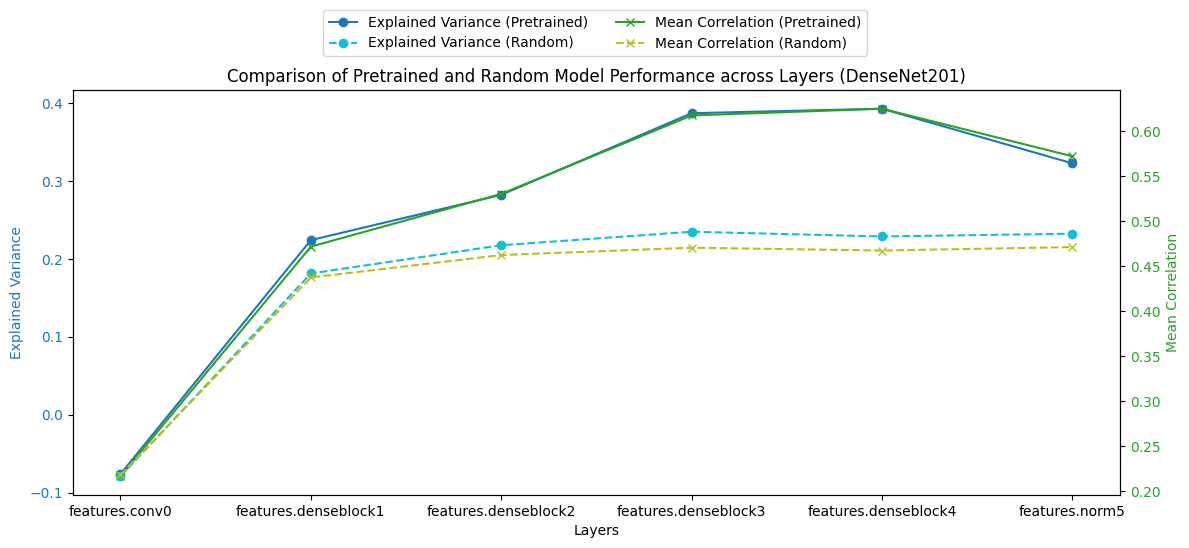

In [32]:
layers_labels = [
    'features.conv0',
    'features.denseblock1',
    'features.denseblock2',
    'features.denseblock3',
    'features.denseblock4',
    'features.norm5'
]

plot_ev_corr_comparison("DenseNet201", layers_labels, results, results_rand)


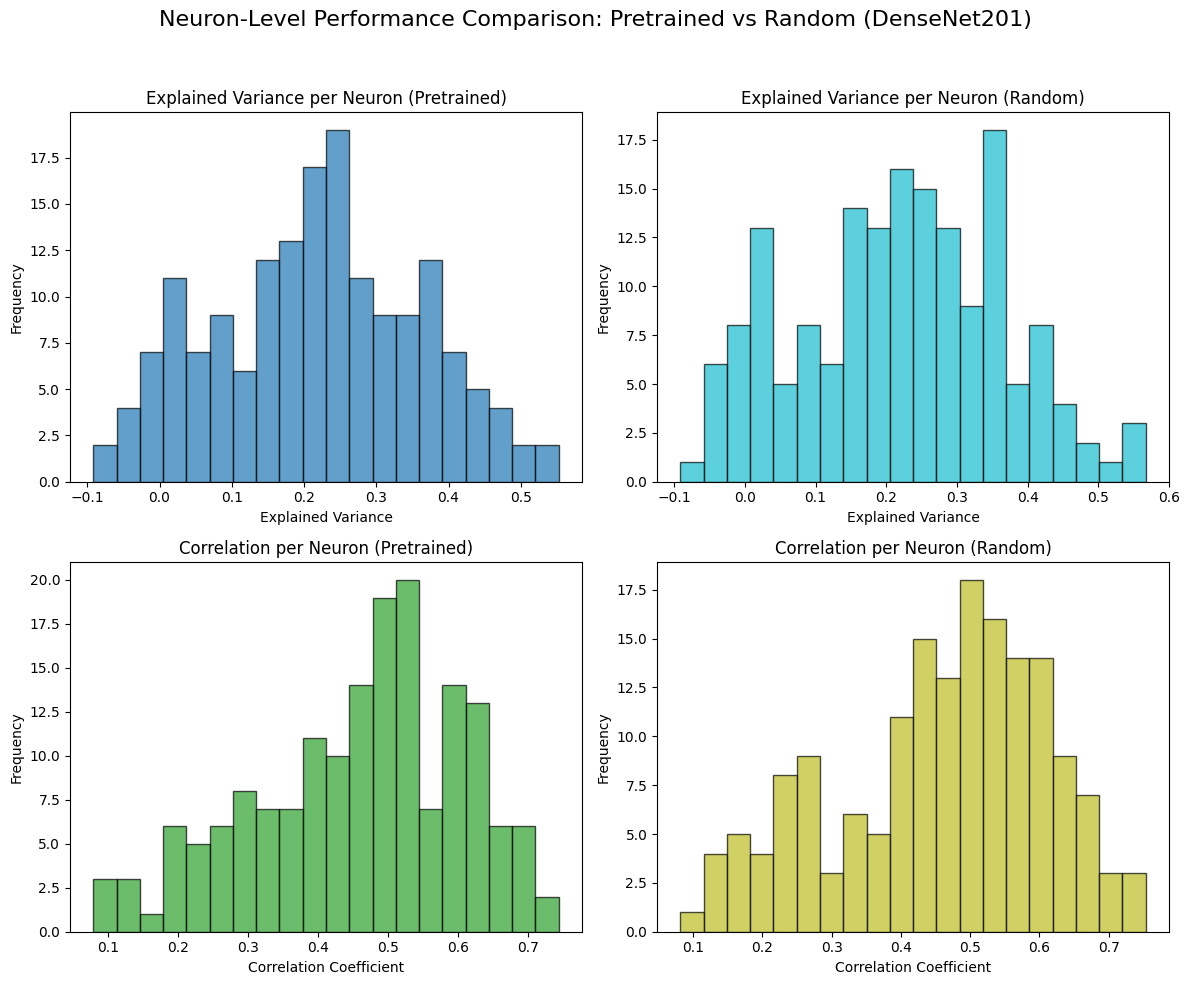

In [25]:
plot_neuron_metrics_hist("DenseNet201", spikes_val, preds_val, preds_val_rand)

## ResNet‑152

### _Layer-wise Evaluation: PCA + Linear Regression on Pretrained ResNet152_

In [34]:
from torchvision.models import resnet152, ResNet152_Weights

# load ImageNet‑pretrained ResNet‑152 (pre‑activation = "v2")
backbone2_pre = resnet152(weights=ResNet152_Weights.IMAGENET1K_V2)

# swap the 1000‑way classifier for NUM_NEURONS regression head
in_features = backbone2_pre.fc.in_features          # 2048
backbone2_pre.fc = nn.Linear(in_features, n_neurons)

model2_pre = backbone2_pre.cuda()
print(f"ResNet‑152 params: {sum(p.numel() for p in model2_pre.parameters()):,}")

layers = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']

results_2 = {}

for layer in layers:
    print(f'Processing {layer}')

    # Extract activations
    train_act_2 = extract_activations(model2_pre, train_loader, layer)
    val_act_2  = extract_activations(model2_pre, val_loader, layer)

    # PCA (use min for safety)
    n_components = min(1000, train_act_rand .shape[1])
    pca_2  = PCA(n_components=n_components, random_state=42)
    X_train_pcs2  = pca_2 .fit_transform(train_act_2)
    X_val_pcs2  = pca_2 .transform(val_act_2)

    # Linear Regression
    lr2  = LinearRegression().fit(X_train_pcs2 , spikes_train )
    preds_val2  = lr2.predict(X_val_pcs2 )

    # Evaluation metrics
    ev_2  = explained_variance_score(spikes_val, preds_val2 )
    correlations_2  = [pearsonr(spikes_val[:, i], preds_val2[:, i])[0] for i in range(spikes_val.shape[1])]
    avg_corr_2  = np.mean(correlations_2 )

    results_2[layer] = {'explained_variance': ev_2, 'mean_correlation': avg_corr_2}

    print(f"{layer} | EV: {ev_2:.4f}, Mean Corr: {avg_corr_2:.4f}")

ResNet‑152 params: 58,488,040
Processing conv1
conv1 | EV: -0.0349, Mean Corr: 0.2350
Processing layer1
layer1 | EV: 0.2668, Mean Corr: 0.5025
Processing layer2
layer2 | EV: 0.3298, Mean Corr: 0.5619
Processing layer3
layer3 | EV: 0.3838, Mean Corr: 0.6096
Processing layer4
layer4 | EV: 0.3126, Mean Corr: 0.5494
Processing avgpool
avgpool | EV: 0.0646, Mean Corr: 0.4106


### _Layer-wise Evaluation: PCA + Linear Regression on Randomly Initialized ResNet152_

In [36]:
from torchvision.models import resnet152, ResNet152_Weights

# load ImageNet ResNet‑152 NO PRETRAINING
backbone2_rand = resnet152(weights=None)

# swap the 1000‑way classifier for NUM_NEURONS regression head
in_features = backbone2_rand.fc.in_features          # 2048
backbone2_rand.fc = nn.Linear(in_features, n_neurons)

model2_rand = backbone2_rand.cuda()
print(f"ResNet‑152 params: {sum(p.numel() for p in model2_pre.parameters()):,}")


layers = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']

results_rand2 = {}

for layer in layers:
    print(f'Processing {layer}')

    # Extract activations
    train_act_rand2 = extract_activations(model2_rand, train_loader, layer)
    val_act_rand2  = extract_activations(model2_rand, val_loader, layer)

    # PCA (use min for safety)
    n_components = min(1000, train_act_rand2 .shape[1])
    pca_rand2  = PCA(n_components=n_components, random_state=42)
    X_train_pcs_rand2  = pca_rand2.fit_transform(train_act_rand2)
    X_val_pcs_rand2  = pca_rand2.transform(val_act_rand2)

    # Linear Regression
    lr_rand2  = LinearRegression().fit(X_train_pcs_rand2 , spikes_train )
    preds_val_rand2  = lr_rand .predict(X_val_pcs_rand2 )

    # Evaluation metrics
    ev_rand2  = explained_variance_score(spikes_val, preds_val_rand2 )
    correlations_rand2  = [pearsonr(spikes_val[:, i], preds_val_rand2[:, i])[0] for i in range(spikes_val.shape[1])]
    avg_corr_rand2  = np.mean(correlations_rand2 )

    results_rand2[layer] = {'explained_variance': ev_rand2, 'mean_correlation': avg_corr_rand2}

    print(f"{layer} | EV: {ev_rand2:.4f}, Mean Corr: {avg_corr_rand2:.4f}")


ResNet‑152 params: 58,488,040
Processing conv1
conv1 | EV: -4.1566, Mean Corr: -0.0171
Processing layer1
layer1 | EV: -2.9456, Mean Corr: 0.0672
Processing layer2
layer2 | EV: -2.8934, Mean Corr: 0.0404
Processing layer3
layer3 | EV: -5.5667, Mean Corr: -0.0071
Processing layer4
layer4 | EV: -0.2496, Mean Corr: -0.0010
Processing avgpool
avgpool | EV: 0.0032, Mean Corr: 0.0568


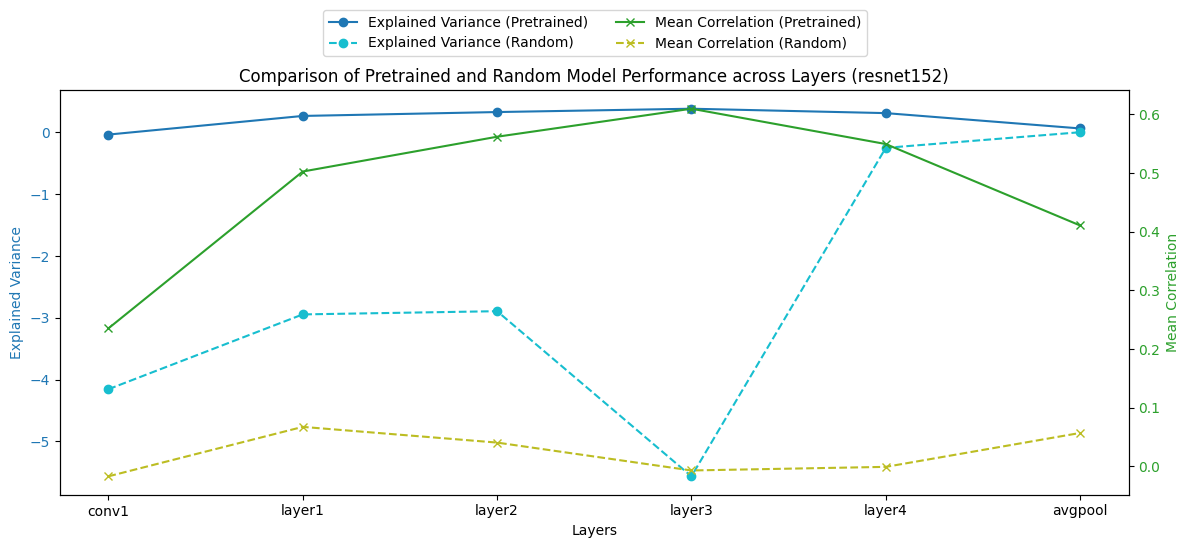

In [39]:
layers_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']

plot_ev_corr_comparison("resnet152", layers_labels, results_2, results_rand2)


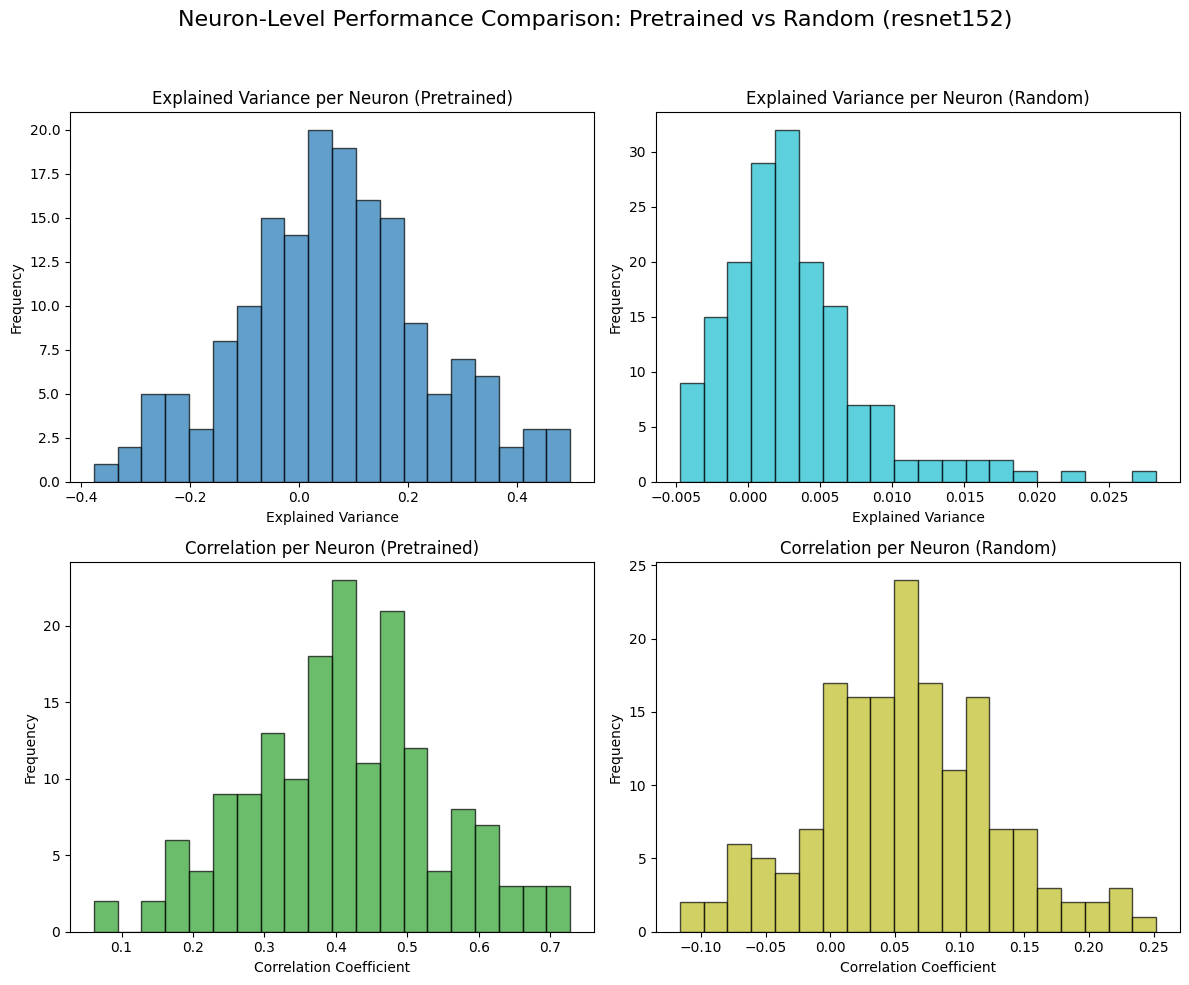

In [40]:
plot_neuron_metrics_hist("resnet152", spikes_val, preds_val2, preds_val_rand2)

## PNASNet‑5 Large

### _Layer-wise Evaluation: PCA + Linear Regression on Pretrained PNASNet‑5 Large_

In [45]:
# ------------------------------------------------------------------
#  PNASNet‑5 Large backbone pretrained on ImageNet‑1k
# ------------------------------------------------------------------
import timm, torch.nn as nn

backbone3_pre = timm.create_model("pnasnet5large", pretrained=True)

# ------------------------------------------------------------------
#  Replace the ImageNet head with a NUM_NEURONS regression head
#     timm models use different attribute names, so check in order
# ------------------------------------------------------------------
if hasattr(backbone3_pre, "classifier"):          # many EfficientNet‑style models
    in_features = backbone3_pre.classifier.in_features
    backbone3_pre.classifier = nn.Linear(in_features, n_neurons)
elif hasattr(backbone3_pre, "fc"):                # ResNet‑style
    in_features = backbone3_pre.fc.in_features
    backbone3_pre.fc = nn.Linear(in_features, n_neurons)
elif hasattr(backbone3_pre, "head"):              # ViT / ConvNeXt‑style
    in_features = backbone3_pre.head.in_features
    backbone3_pre.head = nn.Linear(in_features, n_neurons)
elif hasattr(backbone3_pre, "last_linear"):       # Inception / PNASNet
    in_features = backbone3_pre.last_linear.in_features
    backbone3_pre.last_linear = nn.Linear(in_features, n_neurons)
else:
    raise AttributeError("Cannot locate final classifier layer.")

model3_pre = backbone3_pre.cuda()

print(f"PNASNet‑5 Large parameters: {sum(p.numel() for p in model3_pre.parameters()):,}")


layers = [
    'cell_stem_0',
    'cell_stem_1',
    'cell_0',
    'cell_1',
    'cell_2',
    'cell_3',
    'cell_4',
    'cell_5',
    'cell_6',
    'cell_7',
    'cell_8',
    'cell_9',
    'cell_10',
]


results_3 = {}

for layer in layers:
    print(f'Processing {layer}')

    # Extract activations
    train_act_3 = extract_activations(model3_pre, train_loader, layer)
    val_act_3  = extract_activations(model3_pre, val_loader, layer)

    # PCA (use min for safety)
    n_components = min(1000, train_act_3 .shape[1])
    pca_3  = PCA(n_components=n_components, random_state=42)
    X_train_pcs3  = pca_3 .fit_transform(train_act_3)
    X_val_pcs3  = pca_3 .transform(val_act_3)

    # Linear Regression
    lr3  = LinearRegression().fit(X_train_pcs3 , spikes_train )
    preds_val3  = lr3.predict(X_val_pcs3 )

    # Evaluation metrics
    ev_3  = explained_variance_score(spikes_val, preds_val3 )
    correlations_3  = [pearsonr(spikes_val[:, i], preds_val3[:, i])[0] for i in range(spikes_val.shape[1])]
    avg_corr_3  = np.mean(correlations_3 )

    results_3[layer] = {'explained_variance': ev_3, 'mean_correlation': avg_corr_3}

    print(f"{layer} | EV: {ev_3:.4f}, Mean Corr: {avg_corr_3:.4f}")

PNASNet‑5 Large parameters: 82,462,596
Processing cell_stem_0
cell_stem_0 | EV: 0.2221, Mean Corr: 0.4632
Processing cell_stem_1
cell_stem_1 | EV: 0.2801, Mean Corr: 0.5233
Processing cell_0
cell_0 | EV: 0.2933, Mean Corr: 0.5391
Processing cell_1
cell_1 | EV: 0.2747, Mean Corr: 0.5229
Processing cell_2
cell_2 | EV: 0.3441, Mean Corr: 0.5786
Processing cell_3
cell_3 | EV: 0.3437, Mean Corr: 0.5818
Processing cell_4
cell_4 | EV: 0.3834, Mean Corr: 0.6151
Processing cell_5
cell_5 | EV: 0.3820, Mean Corr: 0.6171
Processing cell_6
cell_6 | EV: 0.3812, Mean Corr: 0.6179
Processing cell_7
cell_7 | EV: 0.3533, Mean Corr: 0.5997
Processing cell_8
cell_8 | EV: 0.3525, Mean Corr: 0.6005
Processing cell_9
cell_9 | EV: 0.3275, Mean Corr: 0.5787
Processing cell_10
cell_10 | EV: 0.2917, Mean Corr: 0.5520


### _Layer-wise Evaluation: PCA + Linear Regression on Randomly initialized PNASNet‑5 Large_

In [46]:
# ------------------------------------------------------------------
#  PNASNet‑5 Large backbone NOT PRETRAINED on ImageNet‑1k
# ------------------------------------------------------------------
import timm, torch.nn as nn

backbone3_rand = timm.create_model("pnasnet5large", pretrained=False)

# ------------------------------------------------------------------
#  Replace the ImageNet head with a NUM_NEURONS regression head
#     timm models use different attribute names, so check in order
# ------------------------------------------------------------------
if hasattr(backbone3_rand, "classifier"):          # many EfficientNet‑style models
    in_features = backbone3_rand.classifier.in_features
    backbone3_rand.classifier = nn.Linear(in_features, n_neurons)
elif hasattr(backbone3_rand, "fc"):                # ResNet‑style
    in_features = backbone3_rand.fc.in_features
    backbone3_rand.fc = nn.Linear(in_features, n_neurons)
elif hasattr(backbone3_rand, "head"):              # ViT / ConvNeXt‑style
    in_features = backbone3_rand.head.in_features
    backbone3_pre.rand = nn.Linear(in_features, n_neurons)
elif hasattr(backbone3_rand, "last_linear"):       # Inception / PNASNet
    in_features = backbone3_rand.last_linear.in_features
    backbone3_rand.last_linear = nn.Linear(in_features, n_neurons)
else:
    raise AttributeError("Cannot locate final classifier layer.")

model3_rand = backbone3_rand.cuda()

print(f"PNASNet‑5 Large parameters: {sum(p.numel() for p in model3_rand.parameters()):,}")

layers = [
    'cell_stem_0',
    'cell_stem_1',
    'cell_0',
    'cell_1',
    'cell_2',
    'cell_3',
    'cell_4',
    'cell_5',
    'cell_6',
    'cell_7',
    'cell_8',
    'cell_9',
    'cell_10',
]

results_3_rand = {}

for layer in layers:
    print(f'Processing {layer}')

    # Extract activations
    train_act_3_rand = extract_activations(model3_rand, train_loader, layer)
    val_act_3_rand  = extract_activations(model3_rand, val_loader, layer)

    # PCA (use min for safety)
    n_components = min(1000, train_act_3_rand .shape[1])
    pca_3_rand  = PCA(n_components=n_components, random_state=42)
    X_train_pcs3_rand  = pca_3_rand .fit_transform(train_act_3_rand)
    X_val_pcs3_rand  = pca_3_rand .transform(val_act_3_rand)

    # Linear Regression
    lr3_rand  = LinearRegression().fit(X_train_pcs3_rand , spikes_train )
    preds_val3_rand  = lr3_rand.predict(X_val_pcs3_rand )

    # Evaluation metrics
    ev_3_rand = explained_variance_score(spikes_val, preds_val3_rand )
    correlations_3_rand  = [pearsonr(spikes_val[:, i], preds_val3_rand[:, i])[0] for i in range(spikes_val.shape[1])]
    avg_corr_3_rand  = np.mean(correlations_3_rand )

    results_3_rand[layer] = {'explained_variance': ev_3_rand, 'mean_correlation': avg_corr_3_rand}

    print(f"{layer} | EV: {ev_3_rand:.4f}, Mean Corr: {avg_corr_3_rand:.4f}")

PNASNet‑5 Large parameters: 82,462,596
Processing cell_stem_0
cell_stem_0 | EV: 0.1762, Mean Corr: 0.4230
Processing cell_stem_1
cell_stem_1 | EV: 0.2082, Mean Corr: 0.4508
Processing cell_0
cell_0 | EV: 0.2410, Mean Corr: 0.4775
Processing cell_1
cell_1 | EV: 0.2482, Mean Corr: 0.4839
Processing cell_2
cell_2 | EV: 0.2441, Mean Corr: 0.4792
Processing cell_3
cell_3 | EV: 0.2408, Mean Corr: 0.4755
Processing cell_4
cell_4 | EV: 0.2291, Mean Corr: 0.4633
Processing cell_5
cell_5 | EV: 0.2150, Mean Corr: 0.4473
Processing cell_6
cell_6 | EV: 0.2019, Mean Corr: 0.4328
Processing cell_7
cell_7 | EV: 0.1908, Mean Corr: 0.4201
Processing cell_8
cell_8 | EV: 0.1723, Mean Corr: 0.3990
Processing cell_9
cell_9 | EV: 0.1453, Mean Corr: 0.3643
Processing cell_10
cell_10 | EV: 0.1293, Mean Corr: 0.3427


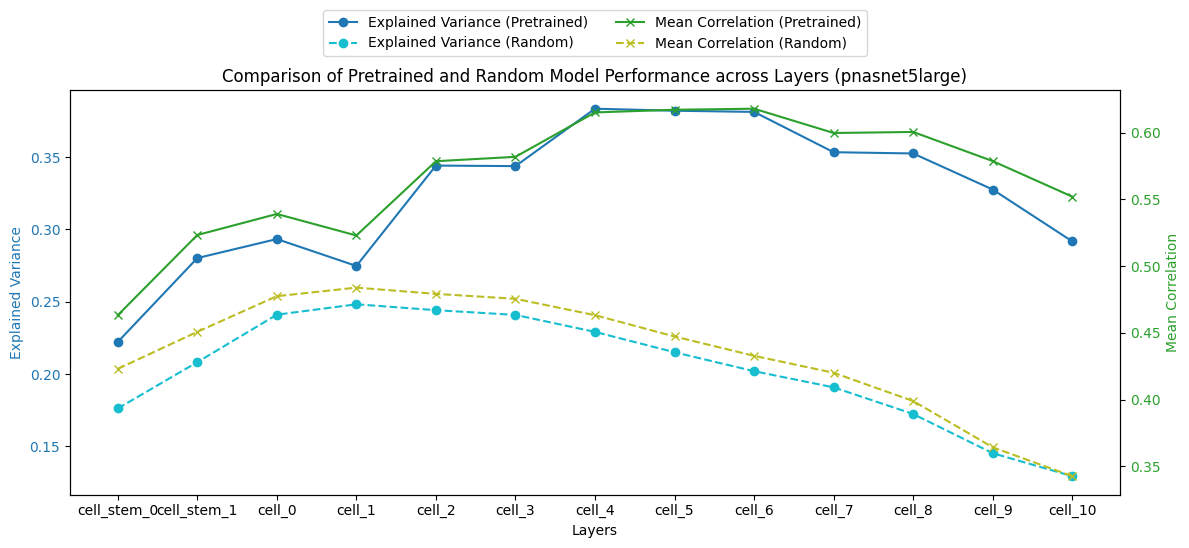

In [47]:
layers_labels = [
    'cell_stem_0',
    'cell_stem_1',
    'cell_0',
    'cell_1',
    'cell_2',
    'cell_3',
    'cell_4',
    'cell_5',
    'cell_6',
    'cell_7',
    'cell_8',
    'cell_9',
    'cell_10',
]

plot_ev_corr_comparison("pnasnet5large", layers_labels, results_3, results_3_rand)

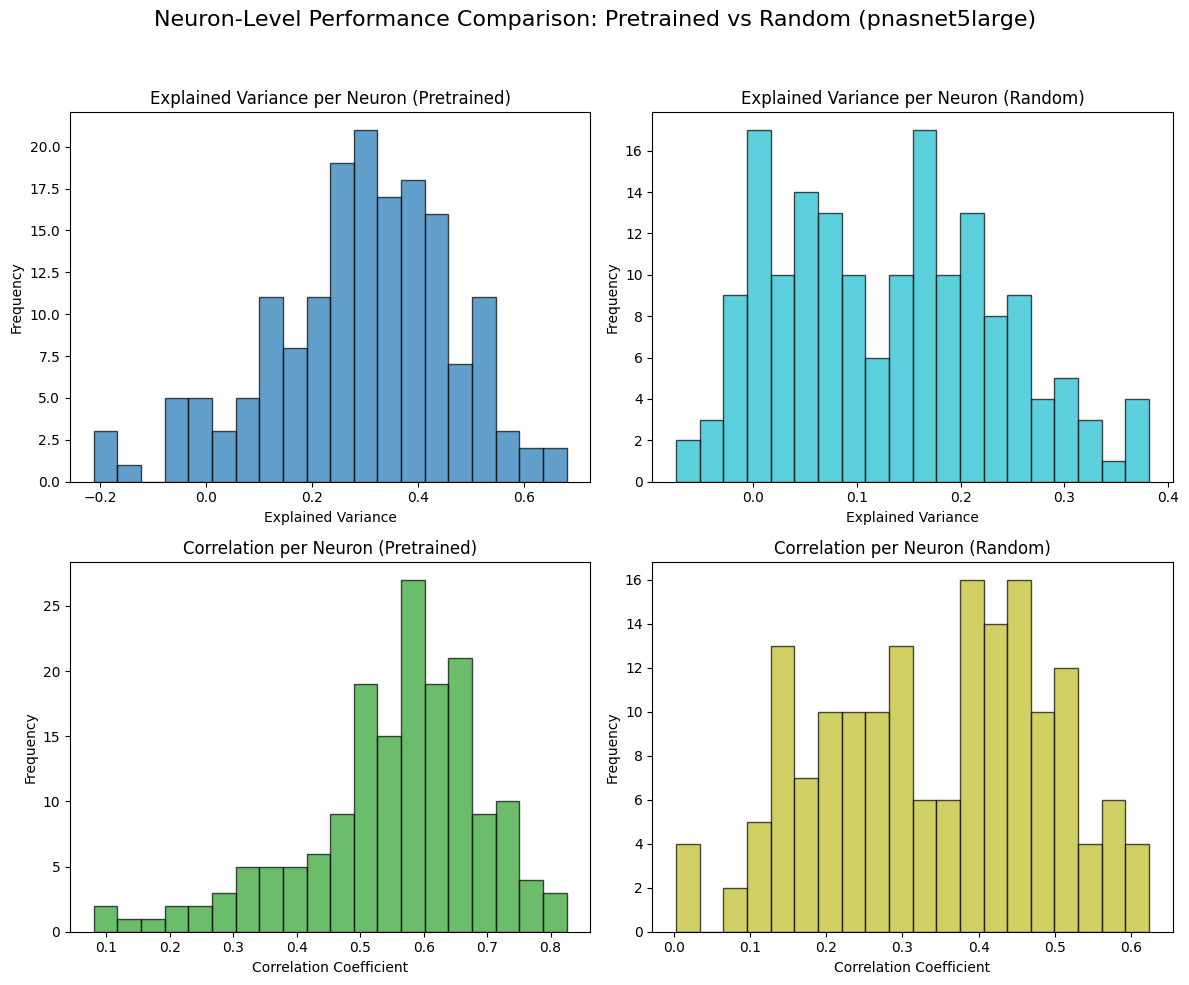

In [68]:
plot_neuron_metrics_hist("pnasnet5large", spikes_val, preds_val3, preds_val3_rand)

---

## **Discussion of Results**

### 1. **Layer-Wise Performance**

* **DenseNet201** (Figure 1):

  * Pretrained model consistently outperforms the random baseline across all layers.
  * Both explained variance and mean correlation increase through the dense blocks and peak at `denseblock3/4`.
  * The pretrained variant offers \~0.4 EV and \~0.6 mean correlation at peak, vs. \~0.25/0.47 for the random model.
  * Suggests strong hierarchical feature buildup beneficial for spike prediction.

* **ResNet152** (Figure 3):

  * Pretrained model has low but positive explained variance across layers; random model shows negative EV — indicating **degenerate decoding**.
  * The pretrained model does better, but not by a large margin — \~0.05–0.1 EV advantage.
  * Performance is unstable, especially at deeper layers (`layer3`, `layer4`), where random initialization collapses entirely (EV ≈ -5).

* **PNASNet-5 Large** (Figure 5):

  * Pretrained and random models diverge most clearly in mid-to-late layers (`cell_3` to `cell_7`).
  * Peak performance from pretrained: \~0.38 EV, \~0.62 correlation.
  * Gradual degradation in late cells (`cell_9`, `cell_10`) may indicate overcompression or loss of spatial resolution.
  * Random model performs decently but with a consistent gap (0.1–0.15 lower).

---

### 2. **Neuron-Level Performance**

* **DenseNet201** (Figure 2):

  * Pretrained histograms show a healthy right skew, with many neurons achieving >0.3 EV and >0.6 correlation.
  * Random model still reasonable but flatter — shows lower spike predictivity across neurons.
  * Confirms that pretrained DenseNet representations align better with population activity.

* **ResNet152** (Figure 4):

  * Pretrained model yields a wide range of explained variances, many close to zero or negative — indicating **weak neuron-wise decoding**.
  * Random model performs very poorly; most EV values are close to zero and correlation centers around \~0.1–0.2.
  * Supports that ResNet152 is suboptimal for this decoding task, both at the population and single-neuron level.

* **PNASNet-5 Large** (Figure 6):

  * Pretrained model’s neurons show strong performance: peaks near 0.5 EV and 0.6–0.7 correlation.
  * Random model is clearly worse, though still competitive relative to ResNet’s pretrained version.
  * Overall spread is tighter and more consistent than ResNet, with fewer neurons at negative or near-zero EV.

---

##  **Summary Table**

| Model            | Init       | Layer-Wise Peak EV | Mean Corr (Peak) | Neuron-Level EV (Dist)         | Neuron-Level Corr (Dist) |
| ---------------- | ---------- | ------------------ | ---------------- | ------------------------------ | ------------------------ |
| **DenseNet201**  | Pretrained | **0.39**           | **0.62**         | Skewed toward 0.3–0.5          | Peak at 0.5–0.7          |
|                  | Random     | \~0.24             | \~0.47           | Lower spread, peak \~0.2–0.4   | Flatter, peaks \~0.4–0.5 |
| **ResNet152**    | Pretrained | \~0.1              | \~0.6            | Mixed, some near 0 or negative | Mostly 0.3–0.6           |
|                  | Random     | **< -4.0**         | **< 0.1**        | Clustered near 0               | Very weak \~0.1–0.2      |
| **PNASNet-5 Lg** | Pretrained | \~0.38             | \~0.62           | Concentrated near 0.4–0.6      | Peak at 0.5–0.7          |
|                  | Random     | \~0.25             | \~0.45           | Lower EV, wider spread         | Peak \~0.3–0.5           |

---

### Final Insight

* **DenseNet201** is the most effective and robust model for predicting neural activity.
* **PNASNet-5 Large** is a close second, with stronger layer-wise consistency but a slight drop in late-stage performance.
* **ResNet152** struggles, particularly when randomly initialized, suggesting that its architectural inductive biases are not well-suited for this spike prediction task.
